# Building machine learning models

Let's build our first basic models for mortality prediction & predicting the hospital length of stay! We previously explored the rich content of the MIMIC database, extracted and preprocessed data so that we could use them in a classifier. Now, we'll build a model for these prediction tasks and evaluate them.

For mortality prediction, which is a binary classification problem, we'll experiment with logistic regression, support, decision trees and random forests.

Hospital length of stay is a regression problem, hence we will use least squares regression and linear ridge regression from the Shogun toolbox.

In [154]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from scipy.stats import ks_2samp
from scipy import interp
from modshogun import *

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')


In [2]:
# SQL database config
sqluser = ''
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = ''
port = 5432
pwd = getpass.getpass()

········


In [35]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [120]:
query = \
"""
-- Table #3: Services
with serv AS
(
SELECT icu.hadm_id, icu.icustay_id, se.curr_service
, CASE
    WHEN curr_service like '%SURG' then 1
    WHEN curr_service = 'ORTHO' then 1
    ELSE 0 END
  as surgical
, RANK() OVER (PARTITION BY icu.hadm_id ORDER BY se.transfertime DESC) as rank
FROM icustays icu
LEFT JOIN services se
 ON icu.hadm_id = se.hadm_id
AND se.transfertime < icu.intime + interval '12' hour
)

-- Table #4: Clinical data + demographics
, co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, first_careunit, admission_type
, icu.los as icu_los
, round((EXTRACT(EPOCH FROM (adm.dischtime-adm.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age_icu_in
, pat.gender
, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
, hospital_expire_flag
, CASE WHEN pat.dod IS NOT NULL 
       AND pat.dod >= icu.intime - interval '6 hour'
       AND pat.dod <= icu.outtime + interval '6 hour' THEN 1 
       ELSE 0 END AS icu_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '30' day THEN 1 
    ELSE 0 END as hospital30day_expire_flag
, CASE WHEN pat.dod IS NOT NULL
    AND pat.dod < adm.admittime + interval '1' year THEN 1 
    ELSE 0 END as hospital1year_expire_flag      
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
INNER JOIN admissions adm
ON adm.hadm_id = icu.hadm_id    
)

-- Table #5: Exclusions
, excl AS
(
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_los, co.hosp_los
  , co.age_icu_in
  , co.gender
  , co.icustay_id_order
  , serv.curr_service
  , co.first_careunit
  , co.hospital_expire_flag
  , co.icu_expire_flag
  , CASE
        WHEN co.icu_los < 1 then 1
    ELSE 0 END
    AS exclusion_los
  , CASE
        WHEN co.age_icu_in < 16 then 1
    ELSE 0 END
    AS exclusion_age
  , CASE 
        WHEN co.icustay_id_order != 1 THEN 1
    ELSE 0 END 
    AS exclusion_first_stay
  , CASE
        WHEN serv.surgical = 1 THEN 1
    ELSE 0 END
    as exclusion_surgical
FROM co
LEFT JOIN serv
  ON  co.icustay_id = serv.icustay_id
  AND serv.rank = 1
)

SELECT vital.icustay_id, vital.subject_id, vital.hadm_id
-- vital signs for the first 24 hours of the icu stay
, HeartRate_Min
, HeartRate_Mean
, HeartRate_Max
, DiasBP_Min
, DiasBP_Max
, SysBP_Min
, SysBP_Max
, MeanBP_Min
, MeanBP_Mean
, MeanBP_Max
, RespRate_Min
, RespRate_Mean
, RespRate_Max
, TempC_Min
, TempC_Max
, SpO2_Min
, SpO2_Max

-- Glasgow coma score
, MinGCS
, GCSMotor
, GCSVerbal
, GCSEyes

-- lab values
, ANIONGAP_min
, ANIONGAP_max
, ALBUMIN_min
, ALBUMIN_max
, BANDS_min
, BANDS_max
, BICARBONATE_min
, BICARBONATE_max
, BILIRUBIN_min
, BILIRUBIN_max
, CREATININE_min
, CREATININE_max
, CHLORIDE_min
, CHLORIDE_max
, lab.GLUCOSE_min
, lab.GLUCOSE_max
, HEMATOCRIT_min
, HEMATOCRIT_max
, HEMOGLOBIN_min
, HEMOGLOBIN_max
, LACTATE_min
, LACTATE_max
, PLATELET_min
, PLATELET_max
, POTASSIUM_min
, POTASSIUM_max
, PTT_min
, PTT_max
, INR_min
, INR_max
, PT_min
, PT_max
, SODIUM_min
, SODIUM_max
, BUN_min
, BUN_max
, WBC_min
, WBC_max

, urineoutput

-- whether the patient is ventilated on the first day of the ICU stay
, vent

-- demographic data
, co.age_icu_in, co.first_careunit, co.gender, co.admission_type
, hw.height_first, hw.weight_first

-- outcomes
, co.hospital_expire_flag, co.icu_expire_flag
, co.hosp_los, co.icu_los, co.icustay_id_order
, co.hospital1year_expire_flag, hospital30day_expire_flag

-- exclusions
, excl.exclusion_los, excl.exclusion_age
, excl.exclusion_first_stay, excl.exclusion_surgical

FROM mimiciii_dev.vitalsfirstday vital
LEFT JOIN mimiciii_dev.labsfirstday lab
  ON vital.icustay_id = lab.icustay_id
LEFT JOIN mimiciii_dev.gcsfirstday gcs
  ON vital.icustay_id = gcs.icustay_id
LEFT JOIN mimiciii_dev.uofirstday uo
  ON vital.icustay_id = uo.icustay_id
LEFT JOIN mimiciii_dev.ventfirstday vent
  ON vital.icustay_id = vent.icustay_id
left join co
  ON vital.icustay_id = co.icustay_id
left join public.heightweight hw
  ON vital.icustay_id = hw.icustay_id
left join excl
  on vital.icustay_id = excl.icustay_id;
"""

query_output = pd.read_sql_query(query,con) #.dropna().reset_index(drop=True)
query_output.head()

,icustay_id,subject_id,hadm_id,heartrate_min,heartrate_mean,heartrate_max,diasbp_min,diasbp_max,sysbp_min,sysbp_max,...,icu_expire_flag,hosp_los,icu_los,icustay_id_order,hospital1year_expire_flag,hospital30day_expire_flag,exclusion_los,exclusion_age,exclusion_first_stay,exclusion_surgical
0,263738,13,143045,60.0,83.600000,124.0,53.0,84.0,102.0,151.0,...,0,6.8556,3.6660,1,0,0,0,0,0,0
1,211832,71,111944,98.0,112.444444,137.0,31.0,130.0,94.0,157.0,...,0,4.6618,2.8609,1,0,0,0,0,0,0
2,233150,78,100536,56.0,63.117647,73.0,78.0,119.0,134.0,206.0,...,0,3.9139,1.4891,1,0,0,0,0,0,0
3,233111,101,175533,72.0,87.034483,117.0,19.0,85.0,57.0,182.0,...,0,15.7785,9.8919,1,1,1,0,0,0,0
4,212246,103,130744,42.0,51.500000,60.0,40.0,71.0,112.0,161.0,...,0,7.7347,3.0237,1,1,1,0,0,0,1


In [121]:
query_output.to_csv('./full-features-materialized.csv', index=False)

## First lab measurement visualization

To get a better idea of how laboratory measurements for patients admitted to the ICU, we'll plot the distribution of measurements for survival and non-survival groups.

In [56]:
# Create dictionary of ranges
# Keys should match the lab names in the query below
# Are these values correct given the units? Need to check.

lab_ranges = {'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145]
             }

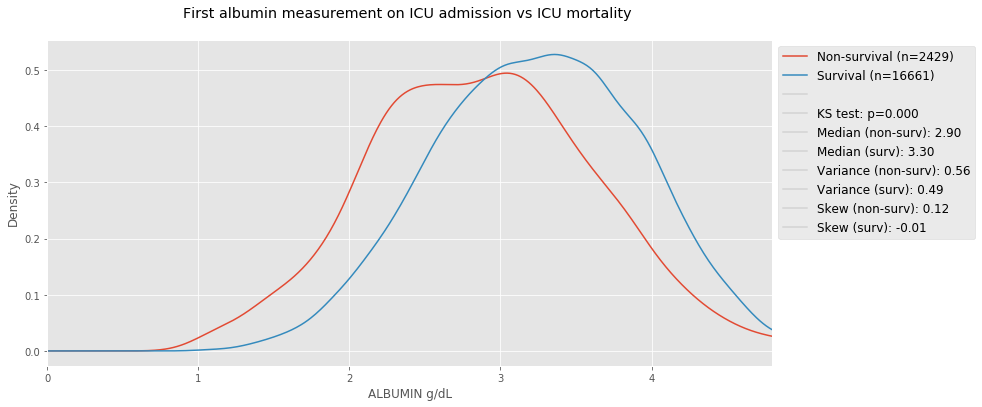

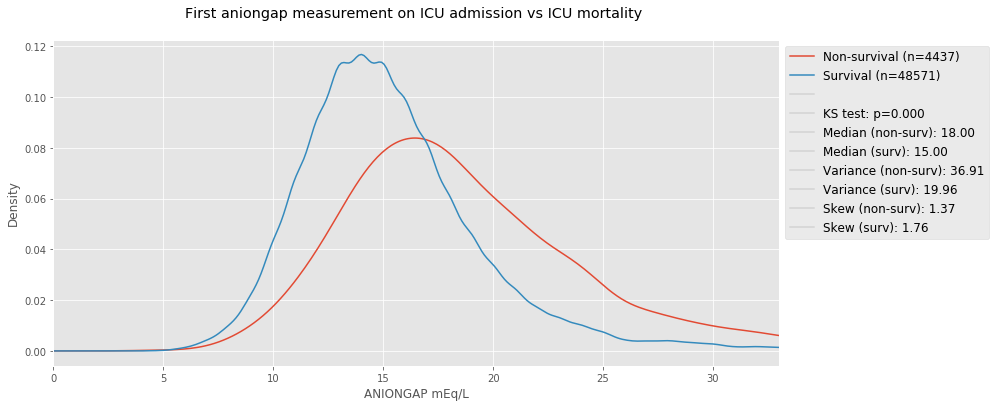

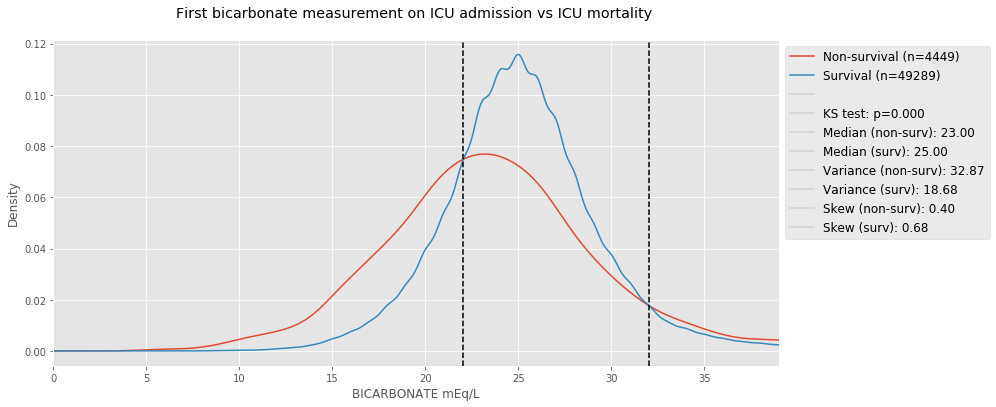

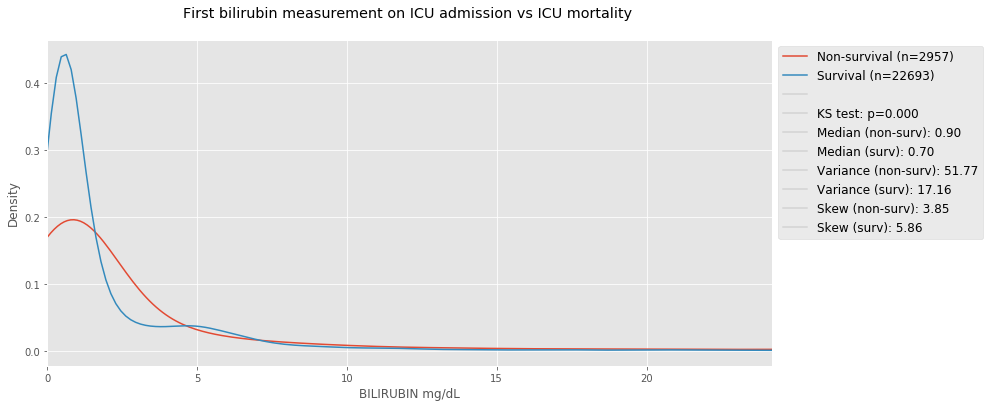

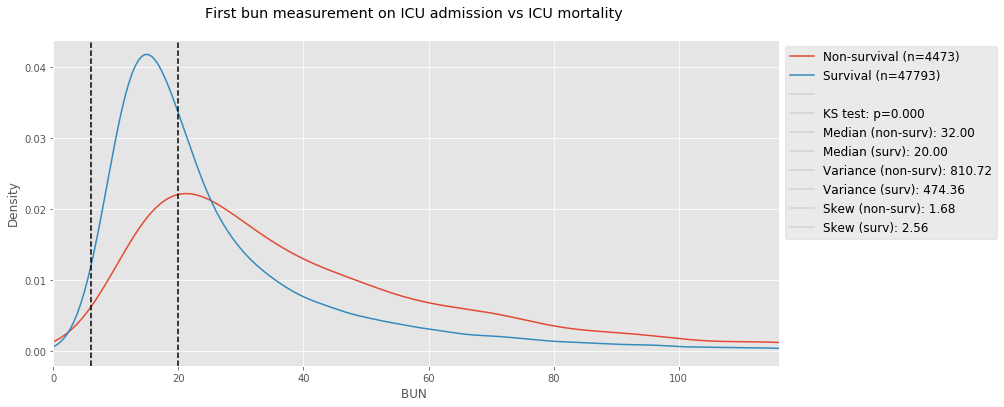

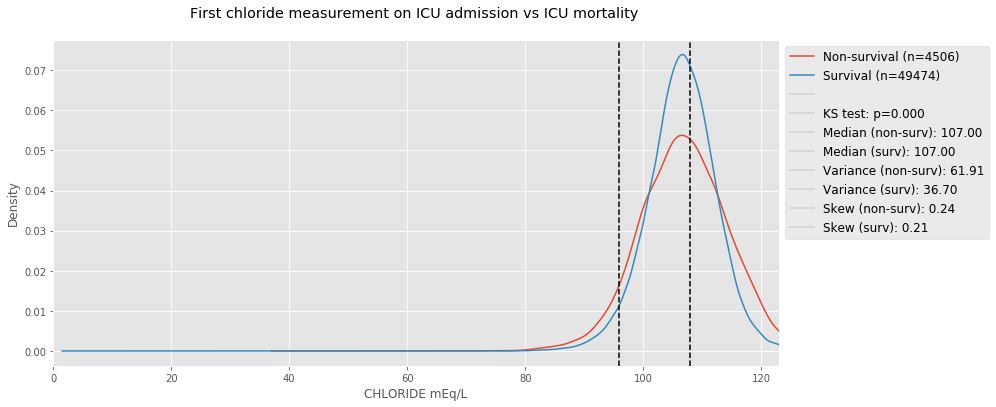

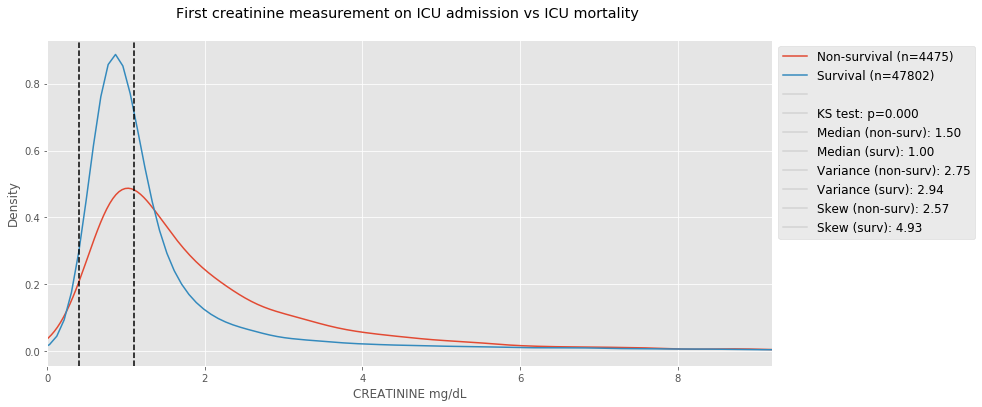

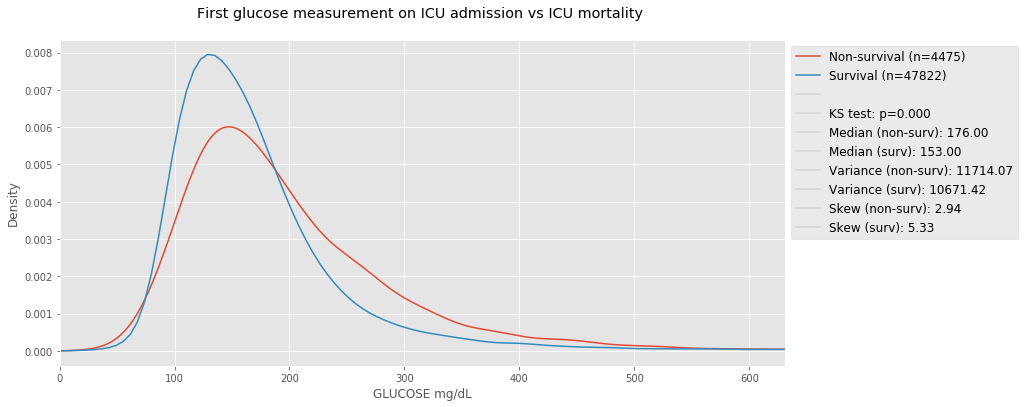

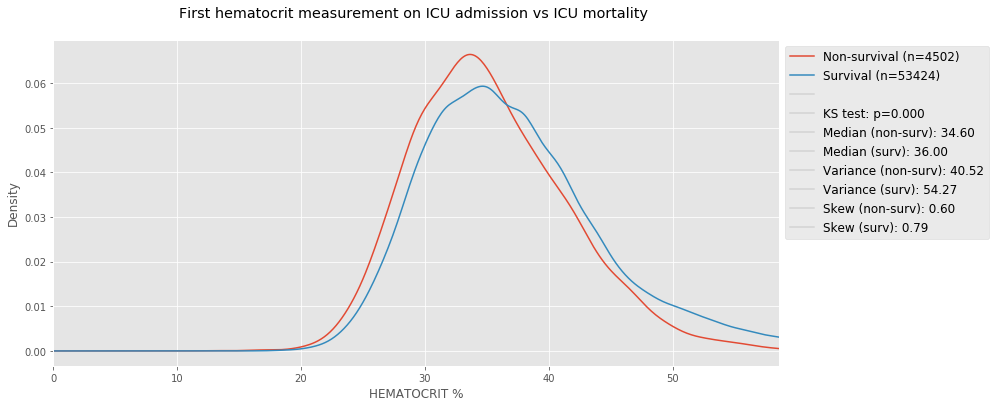

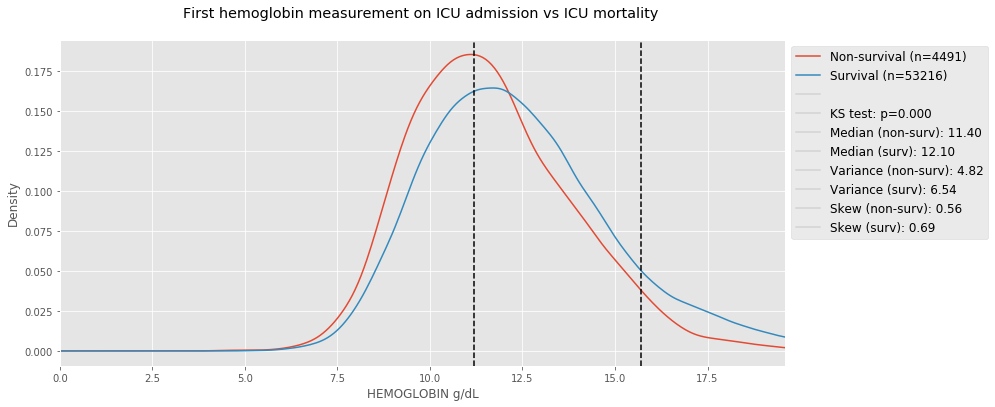

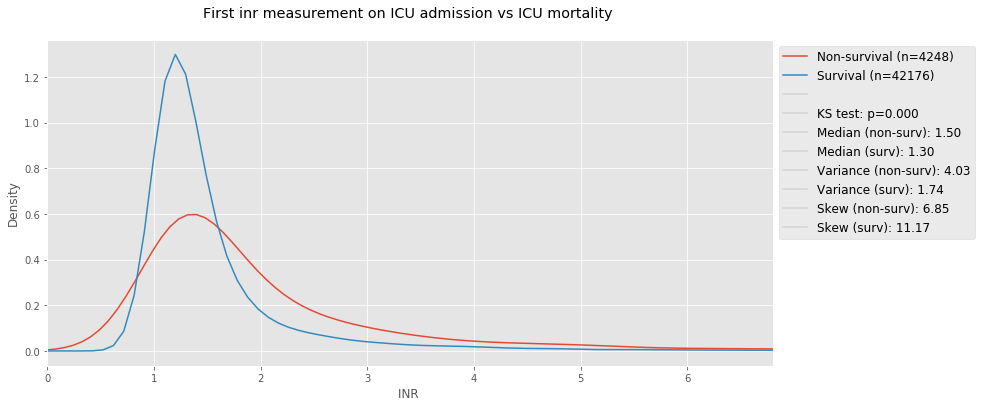

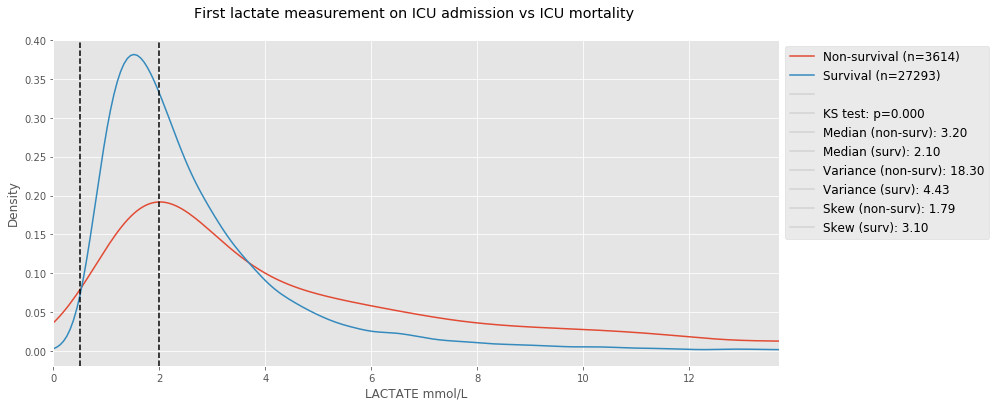

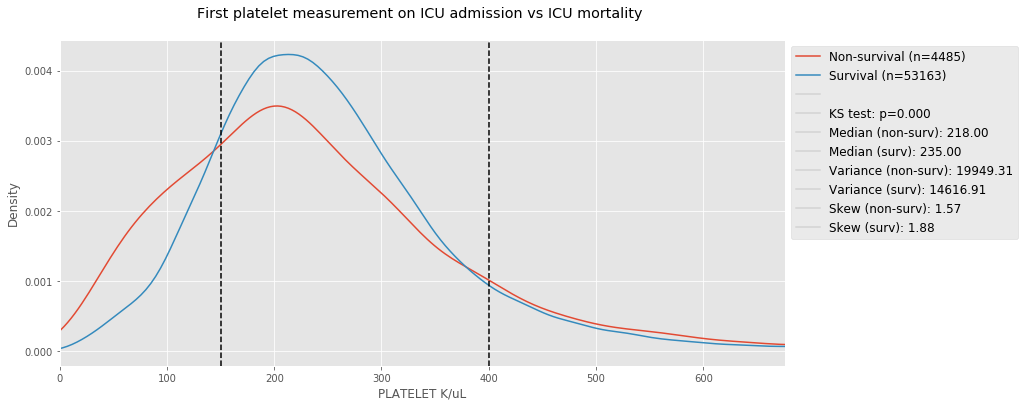

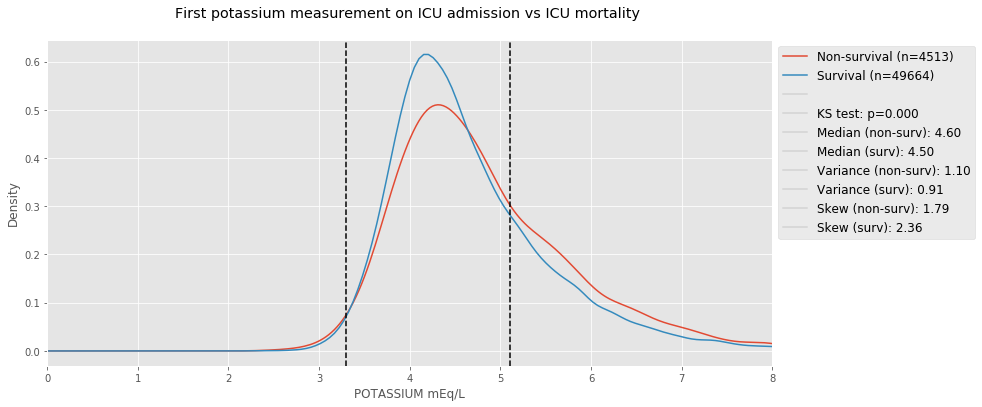

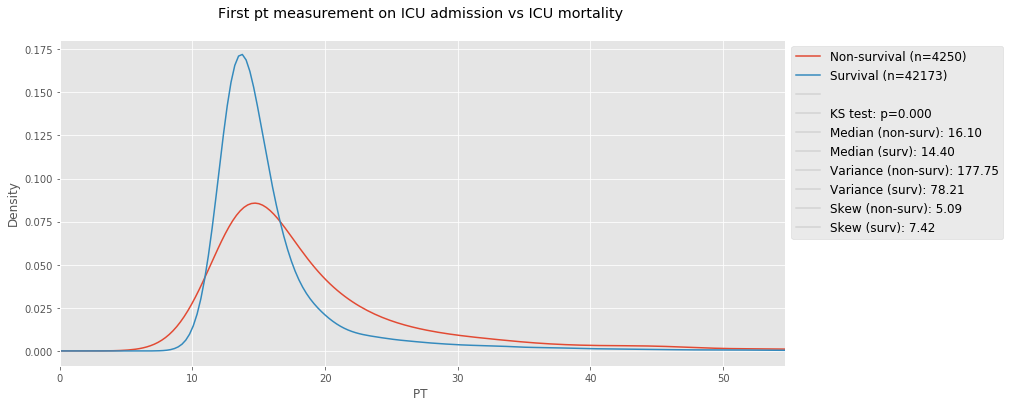

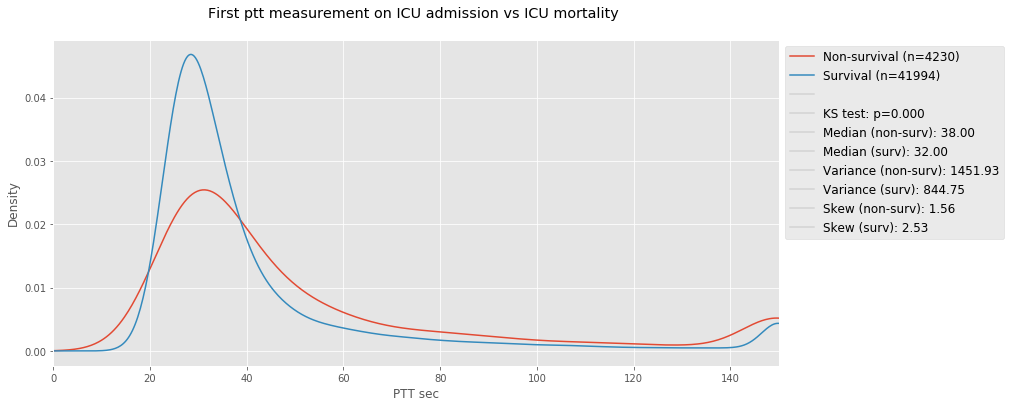

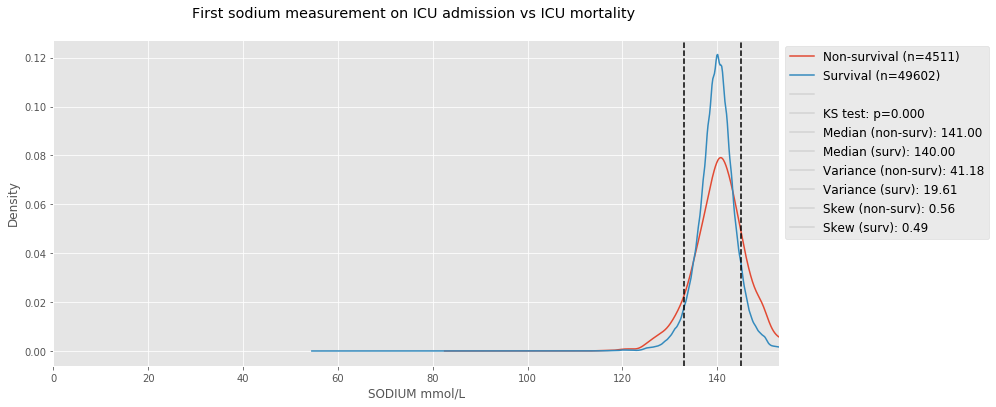

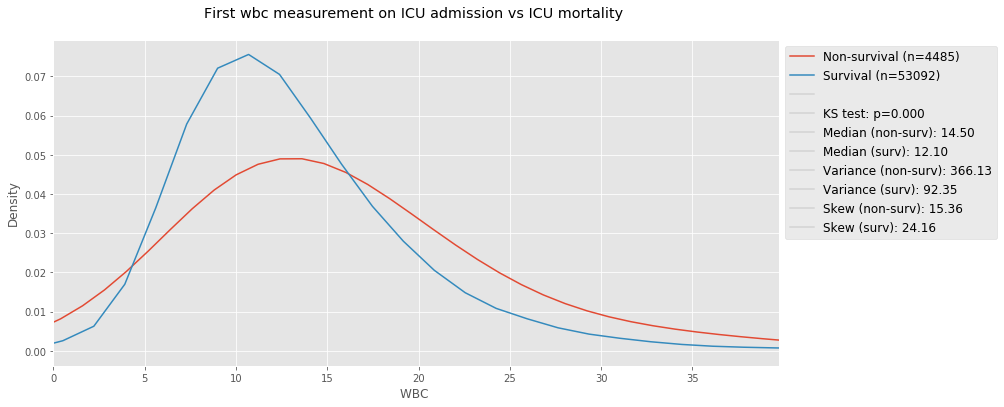

In [73]:
labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}

data = query_output

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().count()
    n_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().median()
    med_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().median()
    var_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().var()
    var_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().skew()
    skew_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().skew() 
    
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_max'][data.icu_expire_flag==1].dropna(),
                              data[l.lower()+'_max'][data.icu_expire_flag==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l.lower()+'_max'].quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## Mortality prediction

We'll now add a few additional mortality outcomes that we'll try to predict. Previously, we only look at whether the patient died in the hospital or not. We'll now try to be more specific and try to predict whether the patient died within the next 30 days and 1 year of being admitted to the hospital, and whether the patient died in the ICU. 

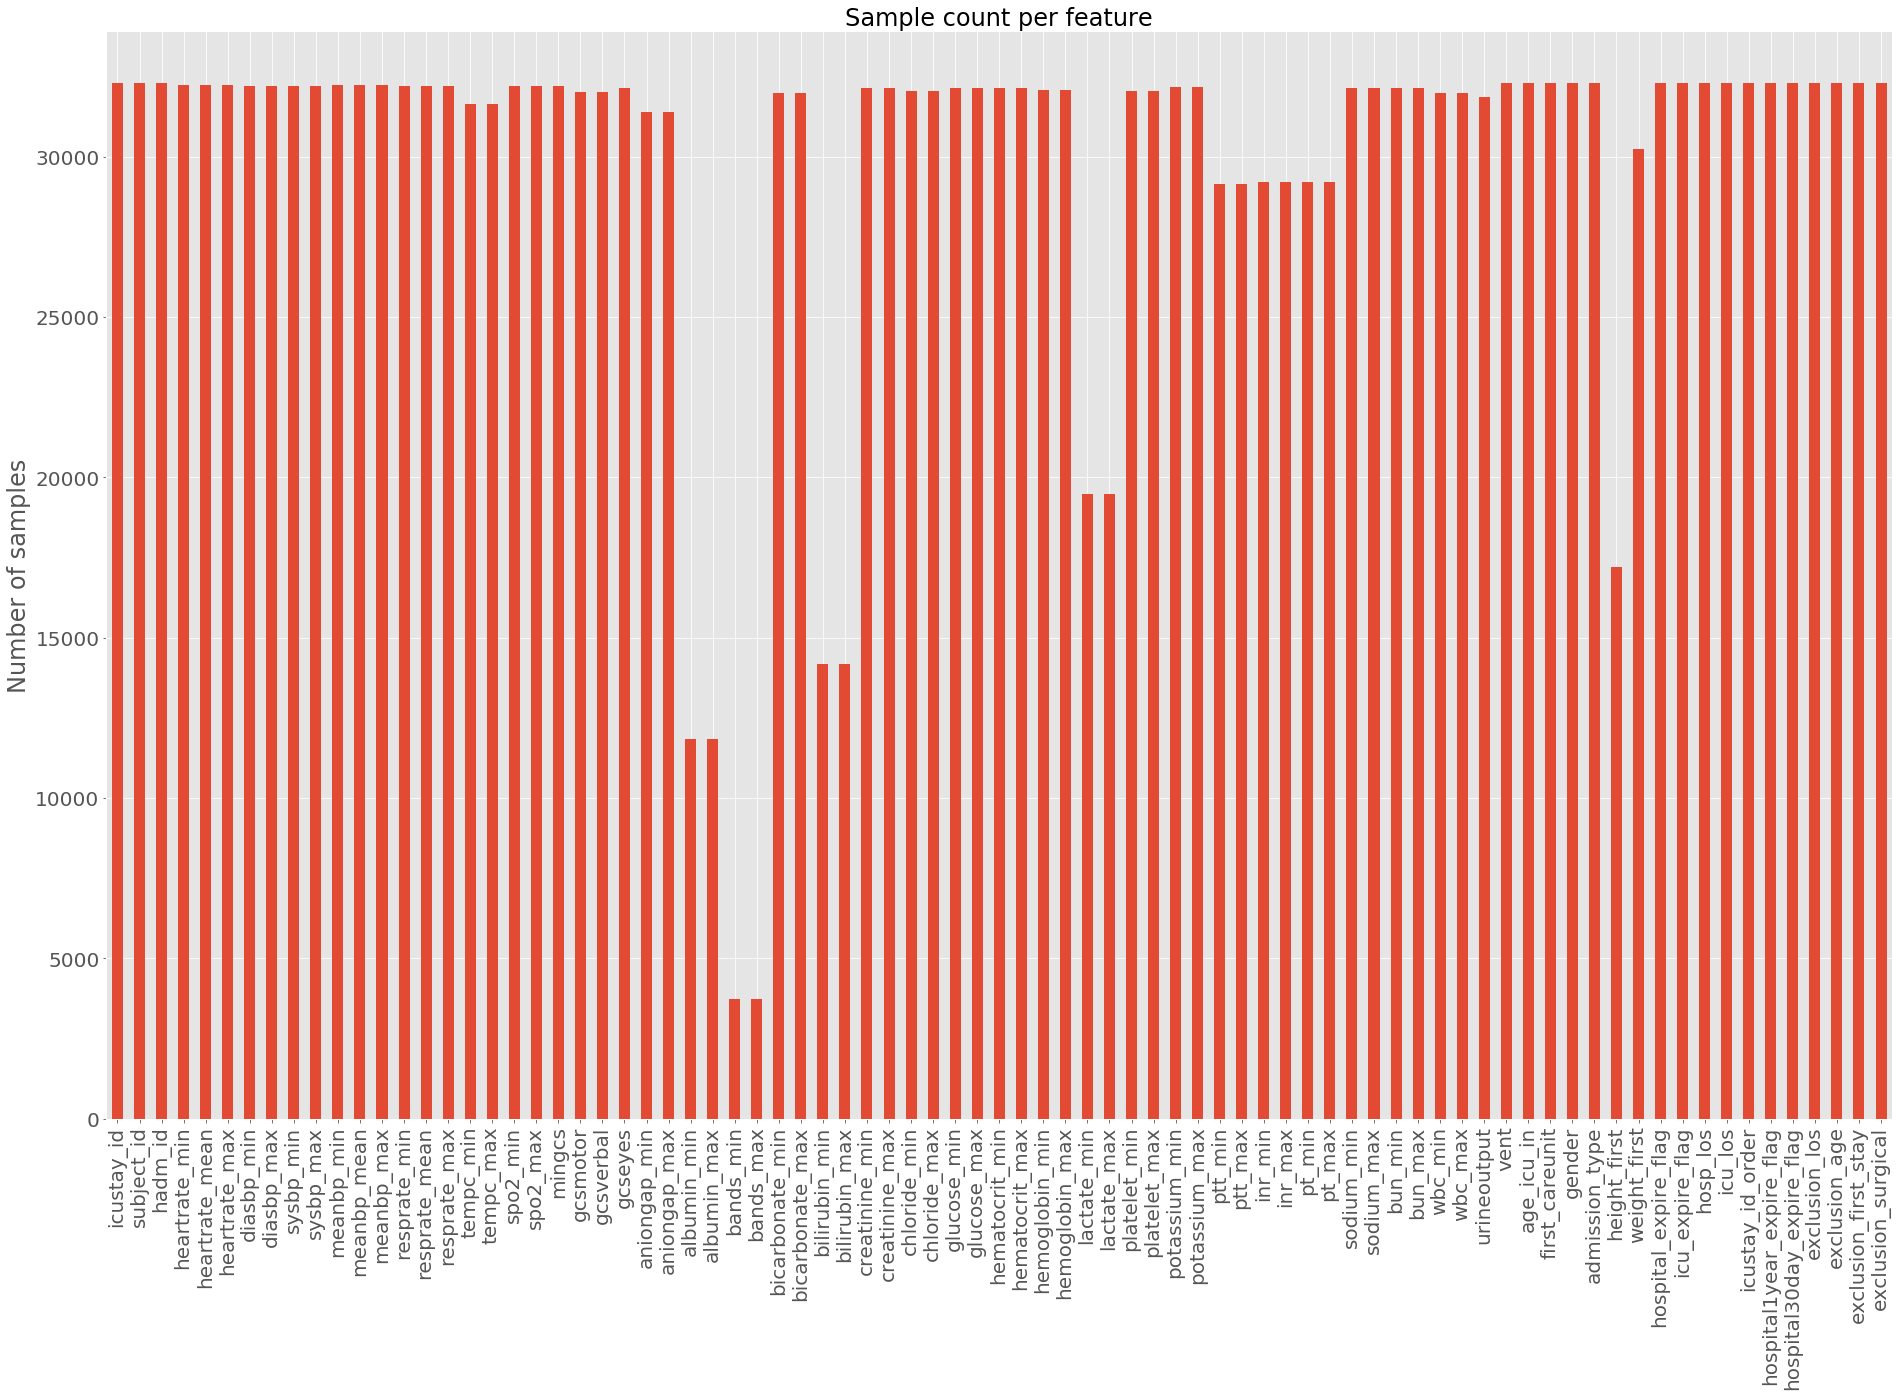

In [134]:
query_output = pd.read_csv('./full-features-materialized.csv') #.dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) & (query_output.exclusion_first_stay == 0)]

ax = query_output.count().plot.bar(figsize=(32, 20), fontsize=20)
ax.set_ylabel('Number of samples', fontsize=24)
ax.set_title('Sample count per feature', fontsize=24)

In [132]:
query_output = pd.read_csv('./full-features-materialized.csv') #.dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) 
                            & (query_output.exclusion_first_stay == 0) ]#& (query_output.age_icu_in < 250)]

# Median age of patients > 89 is 91.6
query_output.loc[query_output.age_icu_in > 89, 'age_icu_in'] = 91.6

mortality_names = ['hospital_expire_flag', 'icu_expire_flag', 
                   'hospital1year_expire_flag', 'hospital30day_expire_flag']

los_names = ['hosp_los', 'icu_los']

feature_names = [
            # Demographic information
            'age_icu_in', 'gender', 'first_careunit',
            'admission_type',
    
            # Vital signs
            'heartrate_min', 'heartrate_max', 
            'meanbp_min', 'meanbp_max', 
            'diasbp_min', 'diasbp_max',
            'sysbp_min', 'sysbp_max',
            'resprate_min', 'resprate_max',
            'mingcs', 'gcsmotor',
            'gcsverbal', 'gcseyes',             
            'tempc_min', 'tempc_max',
            'spo2_min', 'spo2_max',
                 
            # Laboratory measurements
            
            'aniongap_min', 'aniongap_max',
            #'albumin_min', 'albumin_max',
            #'bands_min', 'bands_max',
            'bicarbonate_min', 'bicarbonate_max',
            #'bilirubin_min', 'bilirubin_max',
            'creatinine_min', 'creatinine_max',
            'chloride_min', 'chloride_max',
            'glucose_min', 'glucose_max',
            'hematocrit_min', 'hematocrit_max',
            'hemoglobin_min', 'hemoglobin_max',
            #'lactate_min', 'lactate_max',
            'platelet_min', 'platelet_max',
            'potassium_min', 'potassium_max',
            #'ptt_min', 'ptt_max',
            #'inr_min', 'inr_max',
            #'pt_min', 'pt_max',
            'sodium_min', 'sodium_max',
            'bun_min', 'bun_max',
            'wbc_min', 'wbc_max',                 
            
            # Other
            'vent', 
            'urineoutput'
            ]

query_output = query_output.loc[:, mortality_names + feature_names].dropna().reset_index(drop=True)

outcomes = query_output.loc[:, mortality_names]
features = query_output.loc[:, query_output.columns.difference(mortality_names + los_names)]

X = features
y = outcomes['hospital_expire_flag'].replace(0, -1)

print(len(query_output))
query_output.tail()

29884


,hospital_expire_flag,icu_expire_flag,hospital1year_expire_flag,hospital30day_expire_flag,age_icu_in,gender,first_careunit,admission_type,heartrate_min,heartrate_max,...,potassium_min,potassium_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,vent,urineoutput
29879,0,0,0,0,70.826046,0,5,0,62.0,119.0,...,3.1,3.9,135.0,144.0,7.0,7.0,3.3,4.5,1,1995.0
29880,0,0,0,0,63.893494,0,2,1,60.0,95.0,...,3.5,3.9,139.0,143.0,16.0,31.0,5.3,8.6,0,1400.0
29881,0,0,0,0,43.594414,0,0,1,58.0,80.0,...,3.8,4.1,139.0,140.0,12.0,13.0,11.7,11.8,0,1250.0
29882,1,1,1,1,86.957864,1,2,1,52.0,68.0,...,5.0,5.7,123.0,128.0,41.0,42.0,11.4,13.3,1,730.0
29883,0,0,0,0,77.488270,1,0,1,28.0,74.0,...,4.4,4.9,135.0,138.0,21.0,22.0,10.8,11.0,0,1800.0


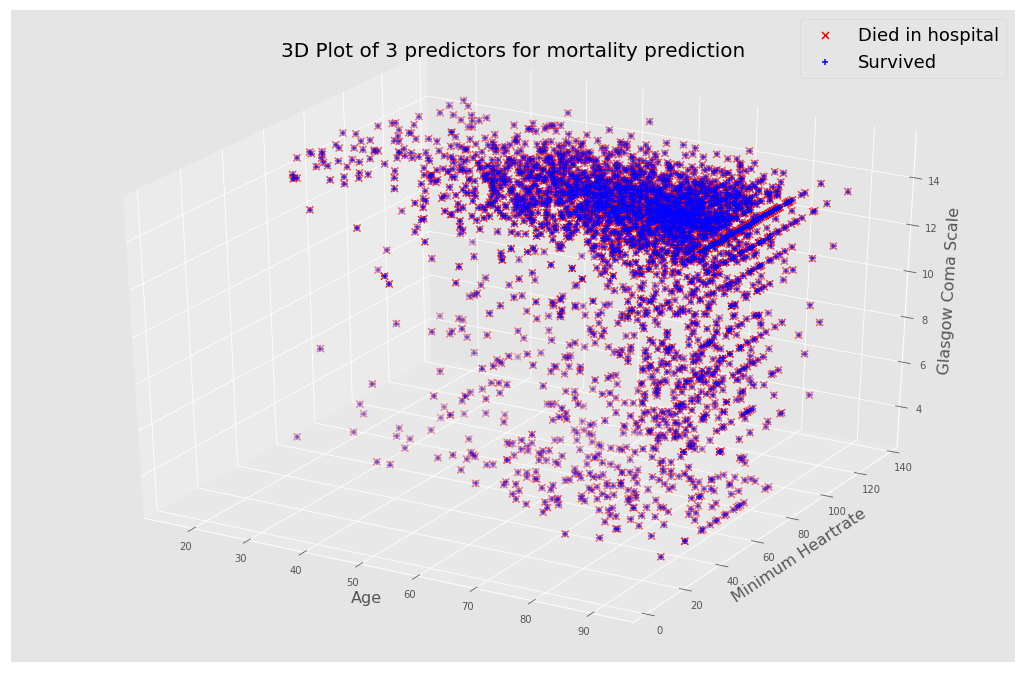

In [142]:
from mpl_toolkits.mplot3d import Axes3D

non_survival = query_output.loc[query_output.hospital_expire_flag == 1, ['age_icu_in', 'heartrate_min', 'mingcs', ]]
survival = query_output.loc[query_output.hospital_expire_flag == 1, ['age_icu_in', 'heartrate_min', 'mingcs', ]]

fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(non_survival.loc[:, non_survival.columns[0]], non_survival.loc[:, non_survival.columns[1]], 
           non_survival.loc[:, non_survival.columns[2]], c='red', marker='x', cmap='coolwarm', s=50, label='Died in hospital')
ax.scatter(survival.loc[:, survival.columns[0]], survival.loc[:, survival.columns[1]], 
           survival.loc[:, survival.columns[2]], c='blue', marker='+', cmap='coolwarm', s=40, label='Survived')

ax.set_xlabel('Age', fontsize=16)
ax.set_ylabel('Minimum Heartrate', fontsize=16)
ax.set_zlabel('Glasgow Coma Scale', fontsize=16)

ax.legend(loc='upper right', fontsize=18)
ax.set_title('3D Plot of 3 predictors for mortality prediction', fontsize=20)

plt.show()

In [143]:
split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = BinaryLabels(np.array(y[:split]))
y_test = BinaryLabels(np.array(y[split:]))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

('Number of training samples:', 20918)
('Number of testing samples:', 8966)


In [144]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train)
svm.set_liblinear_solver_type(L2R_L2LOSS_SVC)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply(X_test)

#use AccuracyMeasure to get accuracy
acc = AccuracyMeasure()
acc.evaluate(y_pred, y_test)

accuracy = acc.get_accuracy() * 100
print('Accuracy(%):', accuracy)

roc = ROCEvaluation()
roc.evaluate(y_pred, y_test)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Accuracy(%):', 89.96207896497882)
('Area under ROC(%):', 0.8437077126884649)
CPU times: user 6.32 s, sys: 6.19 s, total: 12.5 s
Wall time: 4.52 s


In [145]:
%%time

# Parameters to svm
C = 0.1
epsilon = 0.001

svm = LibLinear(C, X_train, y_train)
svm.set_liblinear_solver_type(L2R_LR)
svm.set_epsilon(epsilon)

svm.train()

y_pred = svm.apply(X_test)

lr_roc = ROCEvaluation()
lr_roc.evaluate(y_pred, y_test)

auc = lr_roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.84369129388326)
CPU times: user 8.18 s, sys: 5.99 s, total: 14.2 s
Wall time: 6.1 s


In [31]:
%%time
y_train = MulticlassLabels(np.array(y.replace(-1, 0)[:split].astype(np.float)))
y_test = MulticlassLabels(np.array(y.replace(-1, 0)[split:].astype(np.float)))

feature_types = np.zeros_like(features.columns, dtype=bool)
feature_types[np.where( (features.columns == 'admission_type') | (features.columns == 'first_careunit') |(features.columns == 'gender'))[0]] = True

m_vote = MajorityVote()
rand_forest = RandomForest(X_train, y_train, 150)
rand_forest.set_combination_rule(m_vote)
rand_forest.set_feature_types(feature_types)
rand_forest.train()

y_pred = rand_forest.apply_multiclass(X_test)

# Convert to BinaryLabels()
y_pred_bin = y_pred.get_labels()
y_pred_bin[y_pred_bin == 0] = -1
y_pred_bin = BinaryLabels(y_pred_bin)

y_test_bin = y_test.get_labels()
y_test_bin[y_test_bin == 0] = -1
y_test_bin = BinaryLabels(y_test_bin)

roc = ROCEvaluation()
roc.evaluate(y_pred_bin, y_test_bin)

auc = roc.get_auROC()
print("Area under ROC(%):", auc)

('Area under ROC(%):', 0.5819229859782111)
CPU times: user 1min 45s, sys: 464 ms, total: 1min 45s
Wall time: 29.6 s


## Stratified k-fold cross validation

In [38]:
%%time

features = RealFeatures(np.array(X))
labels = BinaryLabels(np.array(y))

# Parameters to svm
C = 0.1
epsilon = 0.001

k = 10
stratified_split = StratifiedCrossValidationSplitting(labels, k)

metric = ROCEvaluation()

stratified_split.build_subsets()
results = {}
total_results = {}

classifiers = {"LR": L2R_LR, "SVM": L2R_L2LOSS_SVC }#, "RBF": None } #,"LR": L2R_LR}
print("Evaluating classifiers...")
for outcome in mortality_names:
    y = outcomes[outcome].replace(0, -1)
    
    for clf in classifiers:
        aucs = []
        print(clf, outcome)
        for i in range(k):
            train_idx = stratified_split.generate_subset_inverse(i)
            test_idx = stratified_split.generate_subset_indices(i)
            X_train = RealFeatures(np.array(X.loc[train_idx]).T)
            y_train = BinaryLabels(np.array(y.loc[train_idx]))    

            X_test = RealFeatures(np.array(X.loc[test_idx]).T)
            y_test = BinaryLabels(np.array(y.loc[test_idx]))

            if clf == "RBF":
                gauss_kernel = GaussianKernel(X_train, X_train, 15)
                svm = LibSVM(C, gauss_kernel, y_train)
                svm.set_epsilon(epsilon)

            else:
                svm = LibLinear(C, X_train, y_train)
                svm.set_liblinear_solver_type(classifiers[clf])
                svm.set_epsilon(epsilon)

            svm.train()

            y_pred = svm.apply(X_test)

            roc = ROCEvaluation()
            roc.evaluate(y_pred, y_test)

            auc = roc.get_auROC()
            print("Fold", i, " auROC(%): ", auc)    
            aucs.append(auc)
            
            fpr, tpr = roc.get_ROC()
            mean_tpr += interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0

        results[clf] = aucs
        print("Mean auROC across all folds for", clf, ":", np.mean(aucs))
    mean_tpr /= 10.0
    mean_tpr[-1] = 1.0        
    total_results[outcome] = results[clf]

Evaluating classifiers...
SVM
('Fold', 0, ' auROC(%): ', 0.8381239997059048)
('Fold', 1, ' auROC(%): ', 0.844980348271044)
('Fold', 2, ' auROC(%): ', 0.8252004465645151)
('Fold', 3, ' auROC(%): ', 0.8258744620326489)
('Fold', 4, ' auROC(%): ', 0.8286207246523872)
('Fold', 5, ' auROC(%): ', 0.8495878299897357)
('Fold', 6, ' auROC(%): ', 0.8299482421742682)
('Fold', 7, ' auROC(%): ', 0.8192277840701397)
('Fold', 8, ' auROC(%): ', 0.8273693757924894)
('Fold', 9, ' auROC(%): ', 0.8309110592374639)
('Mean auROC across all folds for', 'SVM', ':', 0.83198442724905974)
LR
('Fold', 0, ' auROC(%): ', 0.8351583221639648)
('Fold', 1, ' auROC(%): ', 0.8420968913717417)
('Fold', 2, ' auROC(%): ', 0.8379670038454347)
('Fold', 3, ' auROC(%): ', 0.8286964931032617)
('Fold', 4, ' auROC(%): ', 0.8335983400430899)
('Fold', 5, ' auROC(%): ', 0.8506850705368902)
('Fold', 6, ' auROC(%): ', 0.8351195122941883)
('Fold', 7, ' auROC(%): ', 0.8180737244425981)
('Fold', 8, ' auROC(%): ', 0.8191555848363555)
('Fold

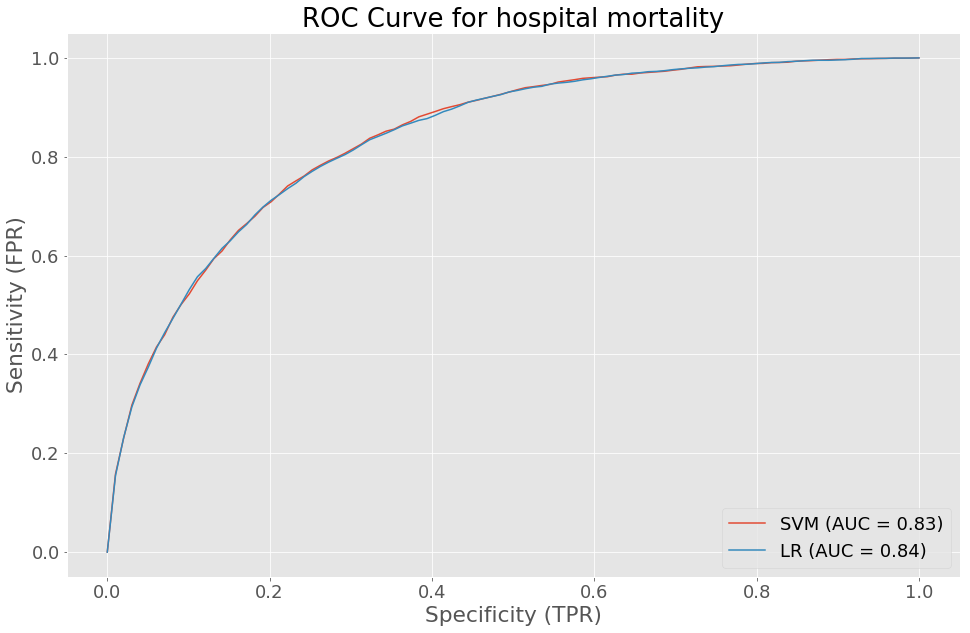

In [162]:
plt.figure(figsize=(16, 10))

plt.plot(mean_fpr_svm, mean_tpr_svm, label='SVM (AUC = %0.2f)' % roc.get_auROC())
plt.plot(mean_fpr, mean_tpr, label='LR (AUC = %0.2f)' % lr_roc.get_auROC())

plt.title('ROC Curve for hospital mortality')
plt.xlabel('Specificity (TPR)')
plt.ylabel('Sensitivity (FPR)')
plt.legend(loc='lower right')

plt.rc('font', size=18)

plt.show()

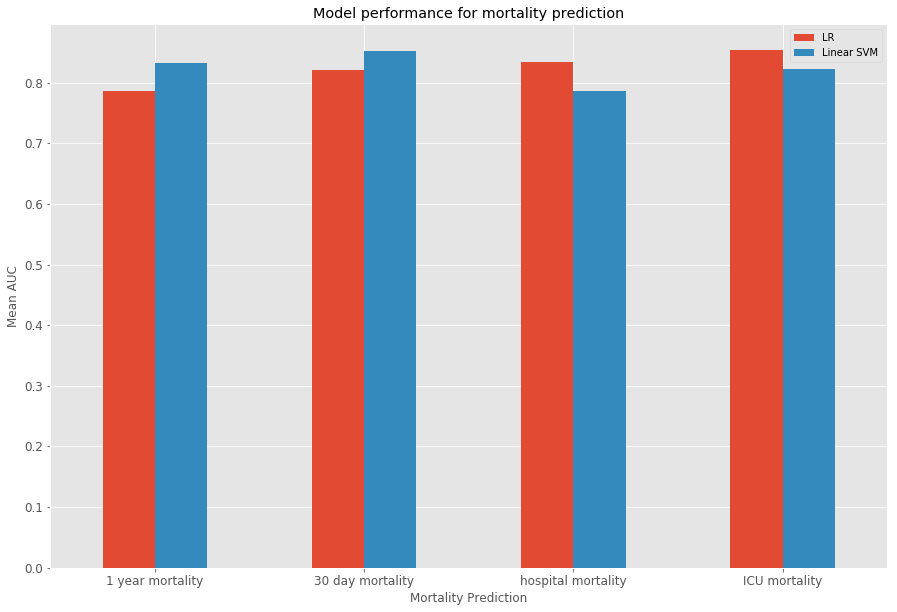

In [130]:
lr_df = pd.DataFrame(lr_results).describe().loc['mean', :]
svm_df = pd.DataFrame(svm_results).describe().loc['mean', :]
results_df = pd.concat((lr_df, svm_df), axis=1, keys=['LR', 'Linear SVM'])
ax = results_df.plot.bar(figsize=(15,10), fontsize=12, title='Model performance for mortality prediction')
ax.set_ylabel('Mean AUC')
ax.set_xticklabels(['1 year mortality', '30 day mortality', 'hospital mortality', 'ICU mortality'], rotation=0)
ax.set_xlabel('Mortality Prediction')

## Length of stay

In [207]:
query_output = pd.read_csv('./full-features-materialized.csv') #.dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) & (query_output.exclusion_first_stay == 0)]

los_names = ['hosp_los', 'icu_los']

feature_names = [
            # Demographic information
            'age_icu_in', 'gender', 'first_careunit',
            'admission_type',
    
            # Vital signs
            'heartrate_min', 'heartrate_max', 
            'meanbp_min', 'meanbp_max', 
            'diasbp_min', 'diasbp_max',
            'sysbp_min', 'sysbp_max',
            'resprate_min', 'resprate_max',
            'mingcs', 'gcsmotor',
            'gcsverbal', 'gcseyes',             
            'tempc_min', 'tempc_max',
            'spo2_min', 'spo2_max',
                 
            # Laboratory measurements
            
            'aniongap_min', 'aniongap_max',
            #'albumin_min', 'albumin_max',
            #'bands_min', 'bands_max',
            'bicarbonate_min', 'bicarbonate_max',
            #'bilirubin_min', 'bilirubin_max',
            'creatinine_min', 'creatinine_max',
            'chloride_min', 'chloride_max',
            'glucose_min', 'glucose_max',
            'hematocrit_min', 'hematocrit_max',
            'hemoglobin_min', 'hemoglobin_max',
            #'lactate_min', 'lactate_max',
            'platelet_min', 'platelet_max',
            'potassium_min', 'potassium_max',
            #'ptt_min', 'ptt_max',
            #'inr_min', 'inr_max',
            #'pt_min', 'pt_max',
            'sodium_min', 'sodium_max',
            'bun_min', 'bun_max',
            'wbc_min', 'wbc_max',                 
            
            # Other
            'vent', 
            'urineoutput'
            ]

query_output = query_output.loc[:, los_names + feature_names].dropna().reset_index(drop=True)

outcomes = query_output.loc[:, los_names]
features = query_output.loc[:, query_output.columns.difference(los_names)]

X = features
y = outcomes['hosp_los']

print(len(query_output))
query_output.tail()

29884


,hosp_los,icu_los,age_icu_in,gender,first_careunit,admission_type,heartrate_min,heartrate_max,meanbp_min,meanbp_max,...,potassium_min,potassium_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,vent,urineoutput
29879,9.2917,3.8486,70.826046,0,5,0,62.0,119.0,71.0,118.0,...,3.1,3.9,135.0,144.0,7.0,7.0,3.3,4.5,1,1995.0
29880,3.1743,3.1737,63.893494,0,2,1,60.0,95.0,57.0,79.0,...,3.5,3.9,139.0,143.0,16.0,31.0,5.3,8.6,0,1400.0
29881,2.2396,1.2625,43.594414,0,0,1,58.0,80.0,49.0,105.0,...,3.8,4.1,139.0,140.0,12.0,13.0,11.7,11.8,0,1250.0
29882,9.0653,9.1439,86.957864,1,2,1,52.0,68.0,47.0,79.0,...,5.0,5.7,123.0,128.0,41.0,42.0,11.4,13.3,1,730.0
29883,1.6764,1.7034,77.488270,1,0,1,28.0,74.0,37.0,93.0,...,4.4,4.9,135.0,138.0,21.0,22.0,10.8,11.0,0,1800.0


In [208]:
split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = RegressionLabels(np.array(y[:split]))
y_test = RegressionLabels(np.array(y[split:]))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

('Number of training samples:', 20918)
('Number of testing samples:', 8966)


In [229]:
%%time

# Load models
ls = LeastSquaresRegression(X_train, y_train)

tau = 1
rr = LinearRidgeRegression(tau, X_train, y_train)

# Train
ls.train()
rr.train()

metric = MeanSquaredError()

y_pred = ls.apply_regression(X_test)
mse = metric.evaluate(y_pred, y_test)
print("Least square regression MSE:", mse)
y_pred = rr.apply_regression(X_test)
mse = metric.evaluate(y_pred, y_test)
print("Linear ridge regression MSE:", mse)

('Least square regression MSE:', 109.80212226815671)
('Linear ridge regression MSE:', 109.80185604312453)
CPU times: user 168 ms, sys: 48 ms, total: 216 ms
Wall time: 100 ms


In [167]:
%%time

features = RealFeatures(np.array(X))
labels = RegressionLabels(np.array(y))

# Parameters to svm
k = 10
split = CrossValidationSplitting(labels, k)

metric = ROCEvaluation()
split.build_subsets()

classifiers = {'LSR': LeastSquaresRegression(), 'LLR': LinearRidgeRegression()}
tau = 1

regression_results = {}
total_regression_results = {}
total_regression_results['LSR'] = {}
total_regression_results['LLR'] = {}

print("Evaluating classifiers...")
for clf in classifiers:
    for outcome in los_names:
        y = outcomes[outcome]

        mses = []
        for i in range(k):    
            train_idx = split.generate_subset_inverse(i)
            test_idx = split.generate_subset_indices(i)
            X_train = RealFeatures(np.array(X.loc[train_idx]).T)
            y_train = RegressionLabels(np.array(y.loc[train_idx]))    
            X_test = RealFeatures(np.array(X.loc[test_idx]).T)
            y_test = RegressionLabels(np.array(y.loc[test_idx]))

            if clf == 'LLR':
                classifiers[clf].set_tau(tau)

            classifiers[clf].set_features(X_train)
            classifiers[clf].set_labels(y_train)
            #ls = LeastSquaresRegression(X_train, y_train)

            classifiers[clf].train()

            metric = MeanSquaredError()

            y_pred = classifiers[clf].apply_regression(X_test)
            mse = metric.evaluate(y_pred, y_test)
            print("Fold %d, Least square regression MSE:" % i, mse)
            mses.append(mse)
        regression_results[clf] = mses
        print('%s, Mean MSE across all folds:' % clf, np.mean(mses))
        total_regression_results[clf][outcome] = mses

Evaluating classifiers...
('Fold 0, Least square regression MSE:', 109.54171678600034)
('Fold 1, Least square regression MSE:', 113.843852839565)
('Fold 2, Least square regression MSE:', 107.30616756800794)
('Fold 3, Least square regression MSE:', 121.73144347916529)
('Fold 4, Least square regression MSE:', 121.30131587769635)
('Fold 5, Least square regression MSE:', 101.49032273419074)
('Fold 6, Least square regression MSE:', 102.05293586465298)
('Fold 7, Least square regression MSE:', 146.9356552138987)
('Fold 8, Least square regression MSE:', 101.75840821023995)
('Fold 9, Least square regression MSE:', 81.30148373407596)
('LLR, Mean MSE across all folds:', 110.72633023074931)
('Fold 0, Least square regression MSE:', 40.91458698397435)
('Fold 1, Least square regression MSE:', 38.147628389550825)
('Fold 2, Least square regression MSE:', 40.7411935315218)
('Fold 3, Least square regression MSE:', 30.16456778786947)
('Fold 4, Least square regression MSE:', 32.82991733755462)
('Fold 5, Le